# Лабораторная работа №1: Цифровая обработка сигналов
Выполнил студент группы 9381 Никита Шахин, Вариант 18.
### Цель работы
Изучить возможности библиотек Python для решения задач цифровой обработки сигналов.

### Задачи лабораторной работы

1. Освоить Jupyter Notebook.
2. Выполнить загрузку аудио сигнала и построить огибающую (график).
3. Фильтрация (выбрать один из 4 основных типов фильтров). Получить фильтрованный сигнал.
4. Детектор сигнал/шум. Получить сигнал после детектирования.
5. Эффект ”Эхо”. Получить сигнал после работы аудио-эффекта.
6. Бонусное задание: эффект ”Distortion”(классический вариант). Получить сигнал после работы аудио-эффекта.

In [43]:
from scipy.io import  wavfile
import scipy.io

sampleRate, data = wavfile.read('03-01-05-01-01-01-18_A18.wav')


### Загрузка аудио сигнала и построение огибающей кривой
Имеется сигнал $x(i), i = 0,1,...,N-1$. Хотим построить огибающую $y(j), j = 0,1,...,n-1$. Пусть $m = \left[ \frac{N} n \right] $ - число точек в интервале усреднения. Тогда $y(i) = \frac{1} m \displaystyle\sum^{mj+m-1}_{k=mj} |x(k)| $

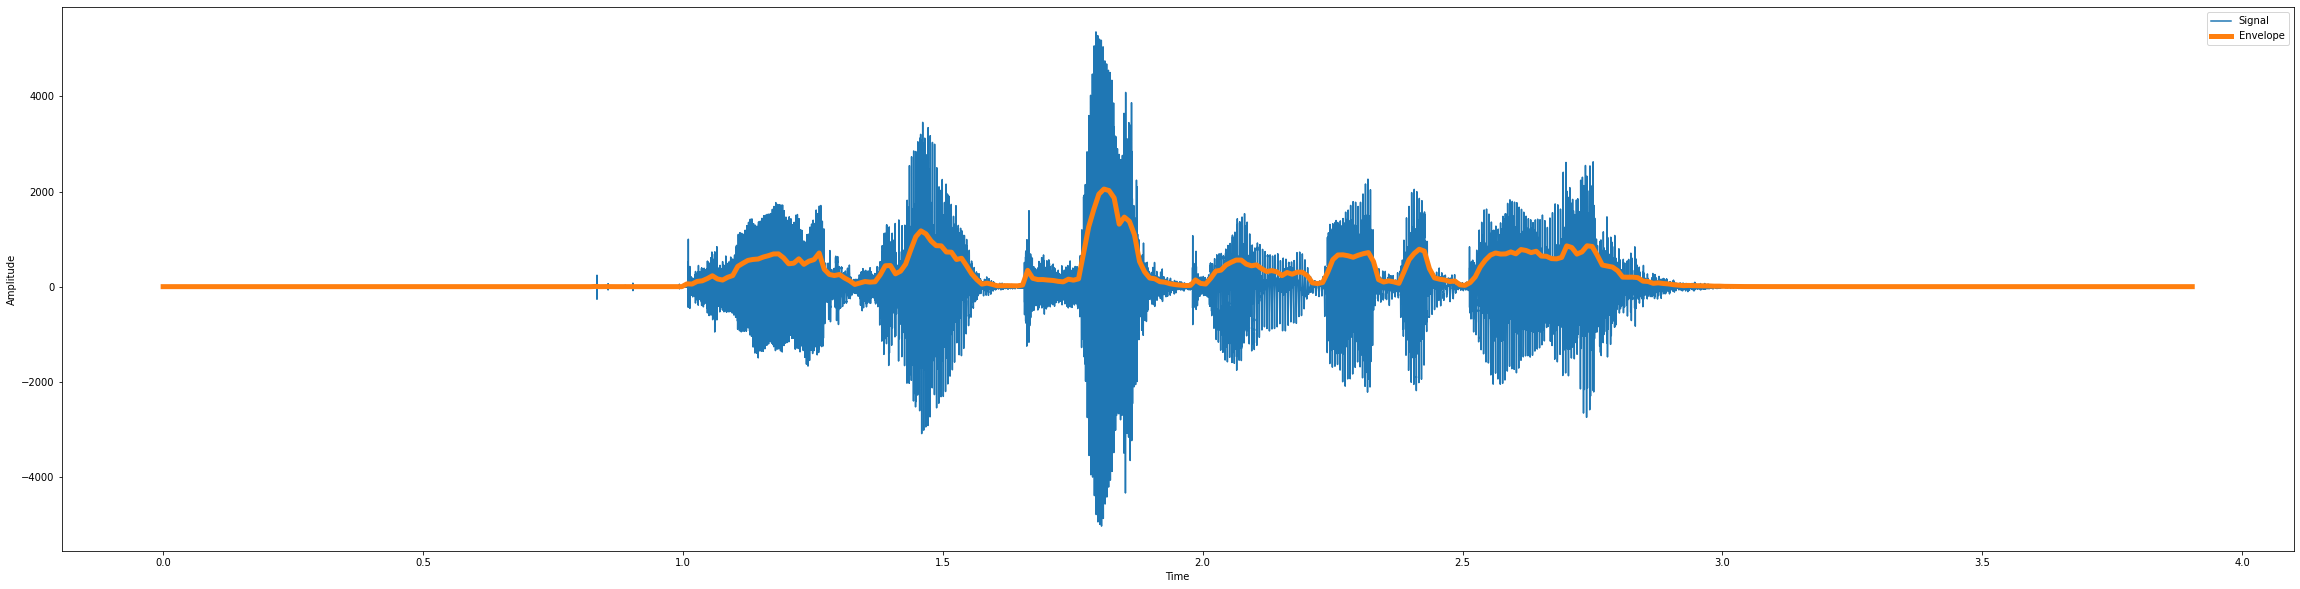

In [44]:
import matplotlib.pyplot as plt
import numpy as np

numDots = 400
lengthSignal = len(data) / sampleRate
time = np.linspace(0, lengthSignal, len(data))
m = int(len(data) / numDots)
curve = np.linspace(0, lengthSignal, numDots)
curveValues = []

for j in range(numDots):
  sum = 0
  for k in range(m * j, m * j + m):
    sum += abs(data[k])
  curveValues.append(sum / m)
  
f = plt.figure()
f.set_figwidth(40)
f.set_figheight(10)
plt.plot(time, data, label="Signal")
plt.plot(curve, curveValues, label="Envelope", linewidth=5)
plt.legend()
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

### Фильтрация сигнала
Был выбран фильтр нижних частот.
Пусть $F_{d}$ - частота дискретизации, частота среза - $F_{s}$, порядок фильтра - $m$. Тогда вычисляем $wn = 2\frac{F_{s}} {F_{d}}$

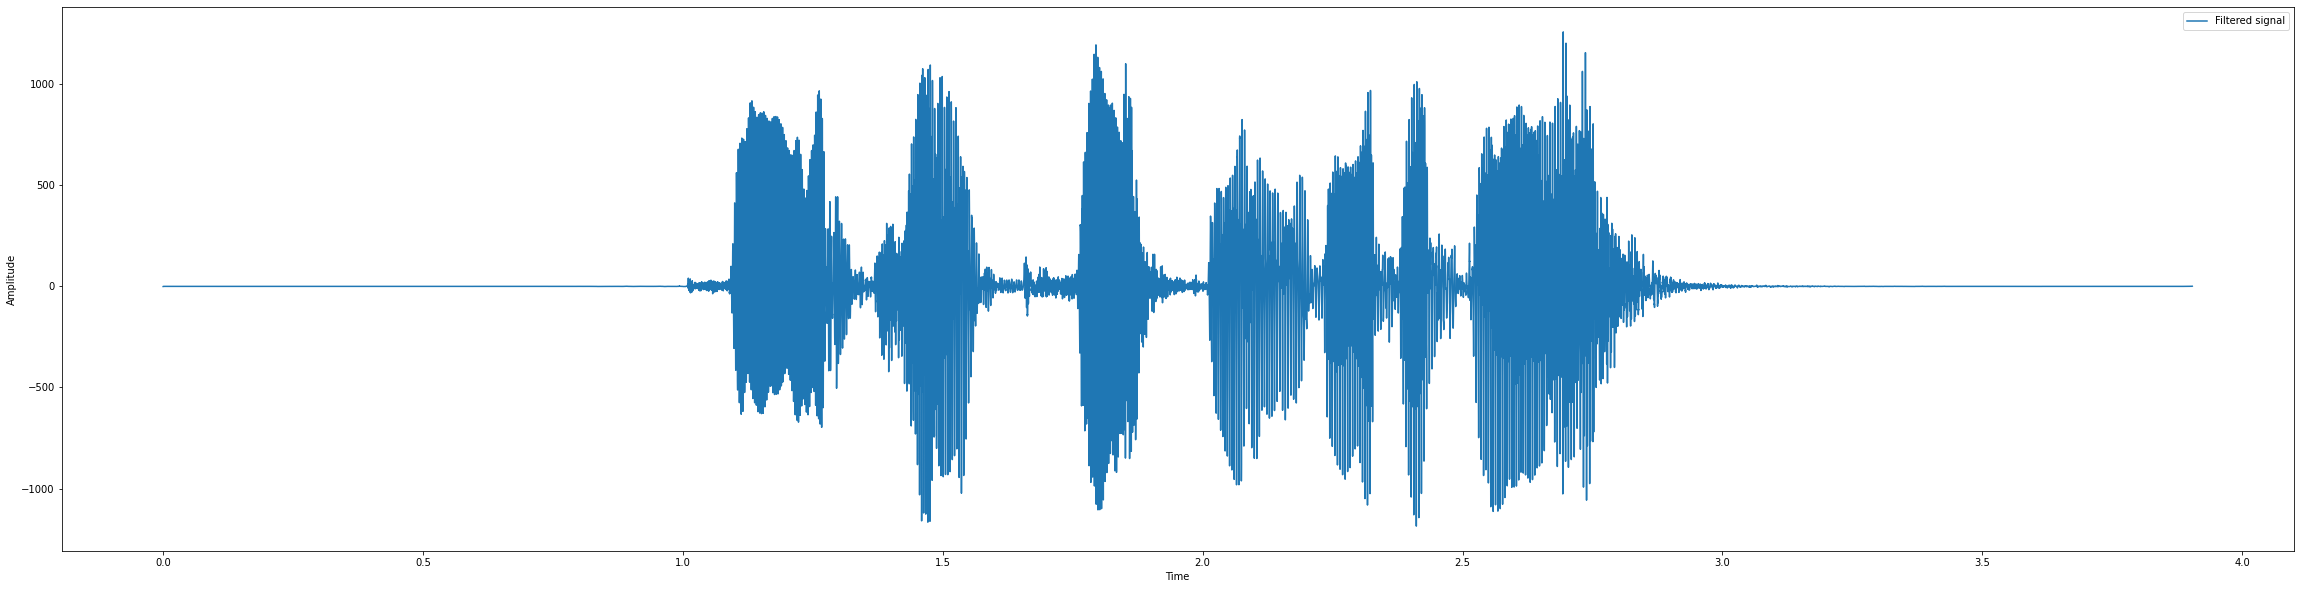

In [45]:
from scipy import signal
Fs = 600
m = 1
wn = 2 * Fs / sampleRate
b, a = signal.butter(m, wn, 'lowpass')
filteredData = signal.filtfilt(b, a, data)

wavfile.write('03-01-05-01-01-01-18_A18_filtered.wav',sampleRate, filteredData.astype(np.int16))

f = plt.figure()
f.set_figwidth(40)
f.set_figheight(10)
plt.plot(time, filteredData, label="Filtered signal")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

### Детектор сигнал/шум
Определяем среднее сигнала по амплитуде (без учета знака): $mid = \frac{1} N \displaystyle\sum^{N-1}_{k=0}|x(k)|$

Определяем порог детектора — $Th = \alpha \cdot mid$, где $0 \lt; \alpha \lt; 1$ подбирается экспериментально. Задаем величину ”провала”(в отсчетах) — $k$. Обозначим $y(i)$ — сигнал после детектирования.

* Событие ”начало сигнала”. Если $x(i)$ в течении $k$ отсчетов превышает порог, $y(i) = x(i)$.
* Событие ”окончание сигнала”. Если $x(i)$ в течении $k$ отсчетов меньше порога, $y(i) = 0$.

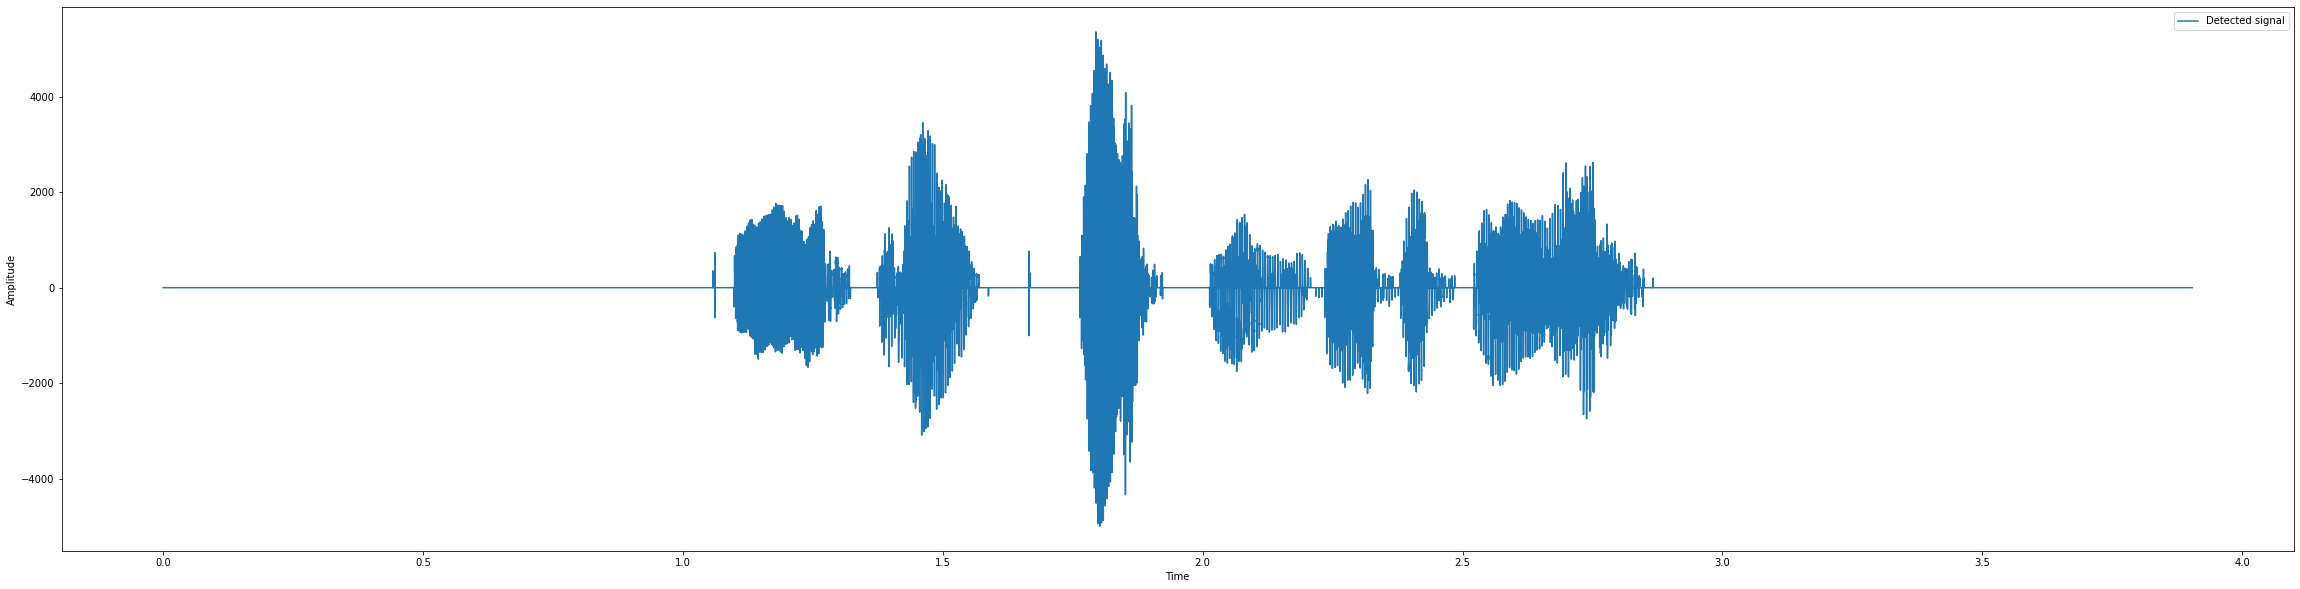

In [46]:
mid = 0
for k in range(len(data)):
  mid += abs(data[k])
mid = mid / len(data)
alpha = 0.75
Th = alpha * mid

k = 12
yi = np.zeros(len(data))
isSignal = False
counterSignal = 0
counterNoSignal = 0

for ind in range(len(data)):
  if abs(data[ind]) > Th:
    counterSignal += 1
    counterNoSignal = 0
    if counterSignal >= k:
      isSignal = True
      yi[ind] = data[ind]
  else:
    counterNoSignal += 1
    counterSignal = 0
    if counterNoSignal >= k:
      isSignal = False

wavfile.write('03-01-05-01-01-01-18_A18_signal.wav',sampleRate, yi.astype(np.int16))    
    
f = plt.figure()
f.set_figwidth(40)
f.set_figheight(10)
plt.plot(time, yi, label="Detected signal")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

### Эффект ”Эхо”
Ревербератор реализован, как набор линий задержки. Число линий задержки $N_{L} \geqslant 8$. Каждая линия задержки имеет свой весовой коэффициент (задается пользователем): $\alpha_{1} \gt \alpha_{2} \gt \dots \gt \alpha_{N_{L}}$.
* Перед добавлением к исходному сигналу, выход ревербератора фильтруется ФНЧ-фильтром первого порядка.
* Желаемое соотношение между ”сухим”и обработанным сигналом задается коэффициентом применимости $\gamma$.
* Ревербератор может работать в двух режимах: ручной и с использованием готовой конфигурации (preset). Для ручного режима регулируется пользователем задается максимальная задержка $D_1$ , а величины остальных определяются автоматически через нее: $D_i = D_1 2 \frac{1-i} {N_L}, i = 2, \dots,N_L$.
Для готовой конфигурации пользователь вручную задает последовательность $D_1 \gt D_2 \gt \dots \gt D_{N_L}$.

In [47]:
Di = np.zeros(8)
gamma = 0.9 
max = float(input("Введите расстояние(в метрах): "))
max = max/335
Di[0] = max
for i in range(1, 8):
    Di[i] = max * (2 ** ((-i)/8))
alpha = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]
changedSignal = np.zeros(int((np.sum(Di) + len(data) / sampleRate + 1) * sampleRate))
for i in range(len(data)-1):
    offset = 0
    for j in range(8):
        offset+=Di[j]   
        changedSignal[i+int(offset*sampleRate)] += data[i] * alpha[j]        
Fs = 900
wn = 2 * Fs / sampleRate
m = 1
b, a = signal.butter(m, wn, "lowpass")
echoSignal = signal.filtfilt(b, a, changedSignal)*gamma
for i in range(len(data)):
    echoSignal[i]+=data[i]

wavfile.write("03-01-05-01-01-01-18_A18_echo.wav", sampleRate, echoSignal.astype(np.int16))

Введите расстояние(в метрах): 15


### Эффект ”Distortion”
Обозначим входной сигнал и выходной сигналы, соответственно как $x(i)$ и $y(i) i = 0,1, \dots, N - 1$. Пользователь задает порог — $Th$ и максимальное значение сигнала $Max \gt Th$.

Тогда $Y(i) = 
 \begin{cases} x(i), |x(i)| \leq Th, \\ Max * sign(x(i)), |x(i)| \gt Th
 \end{cases}
$

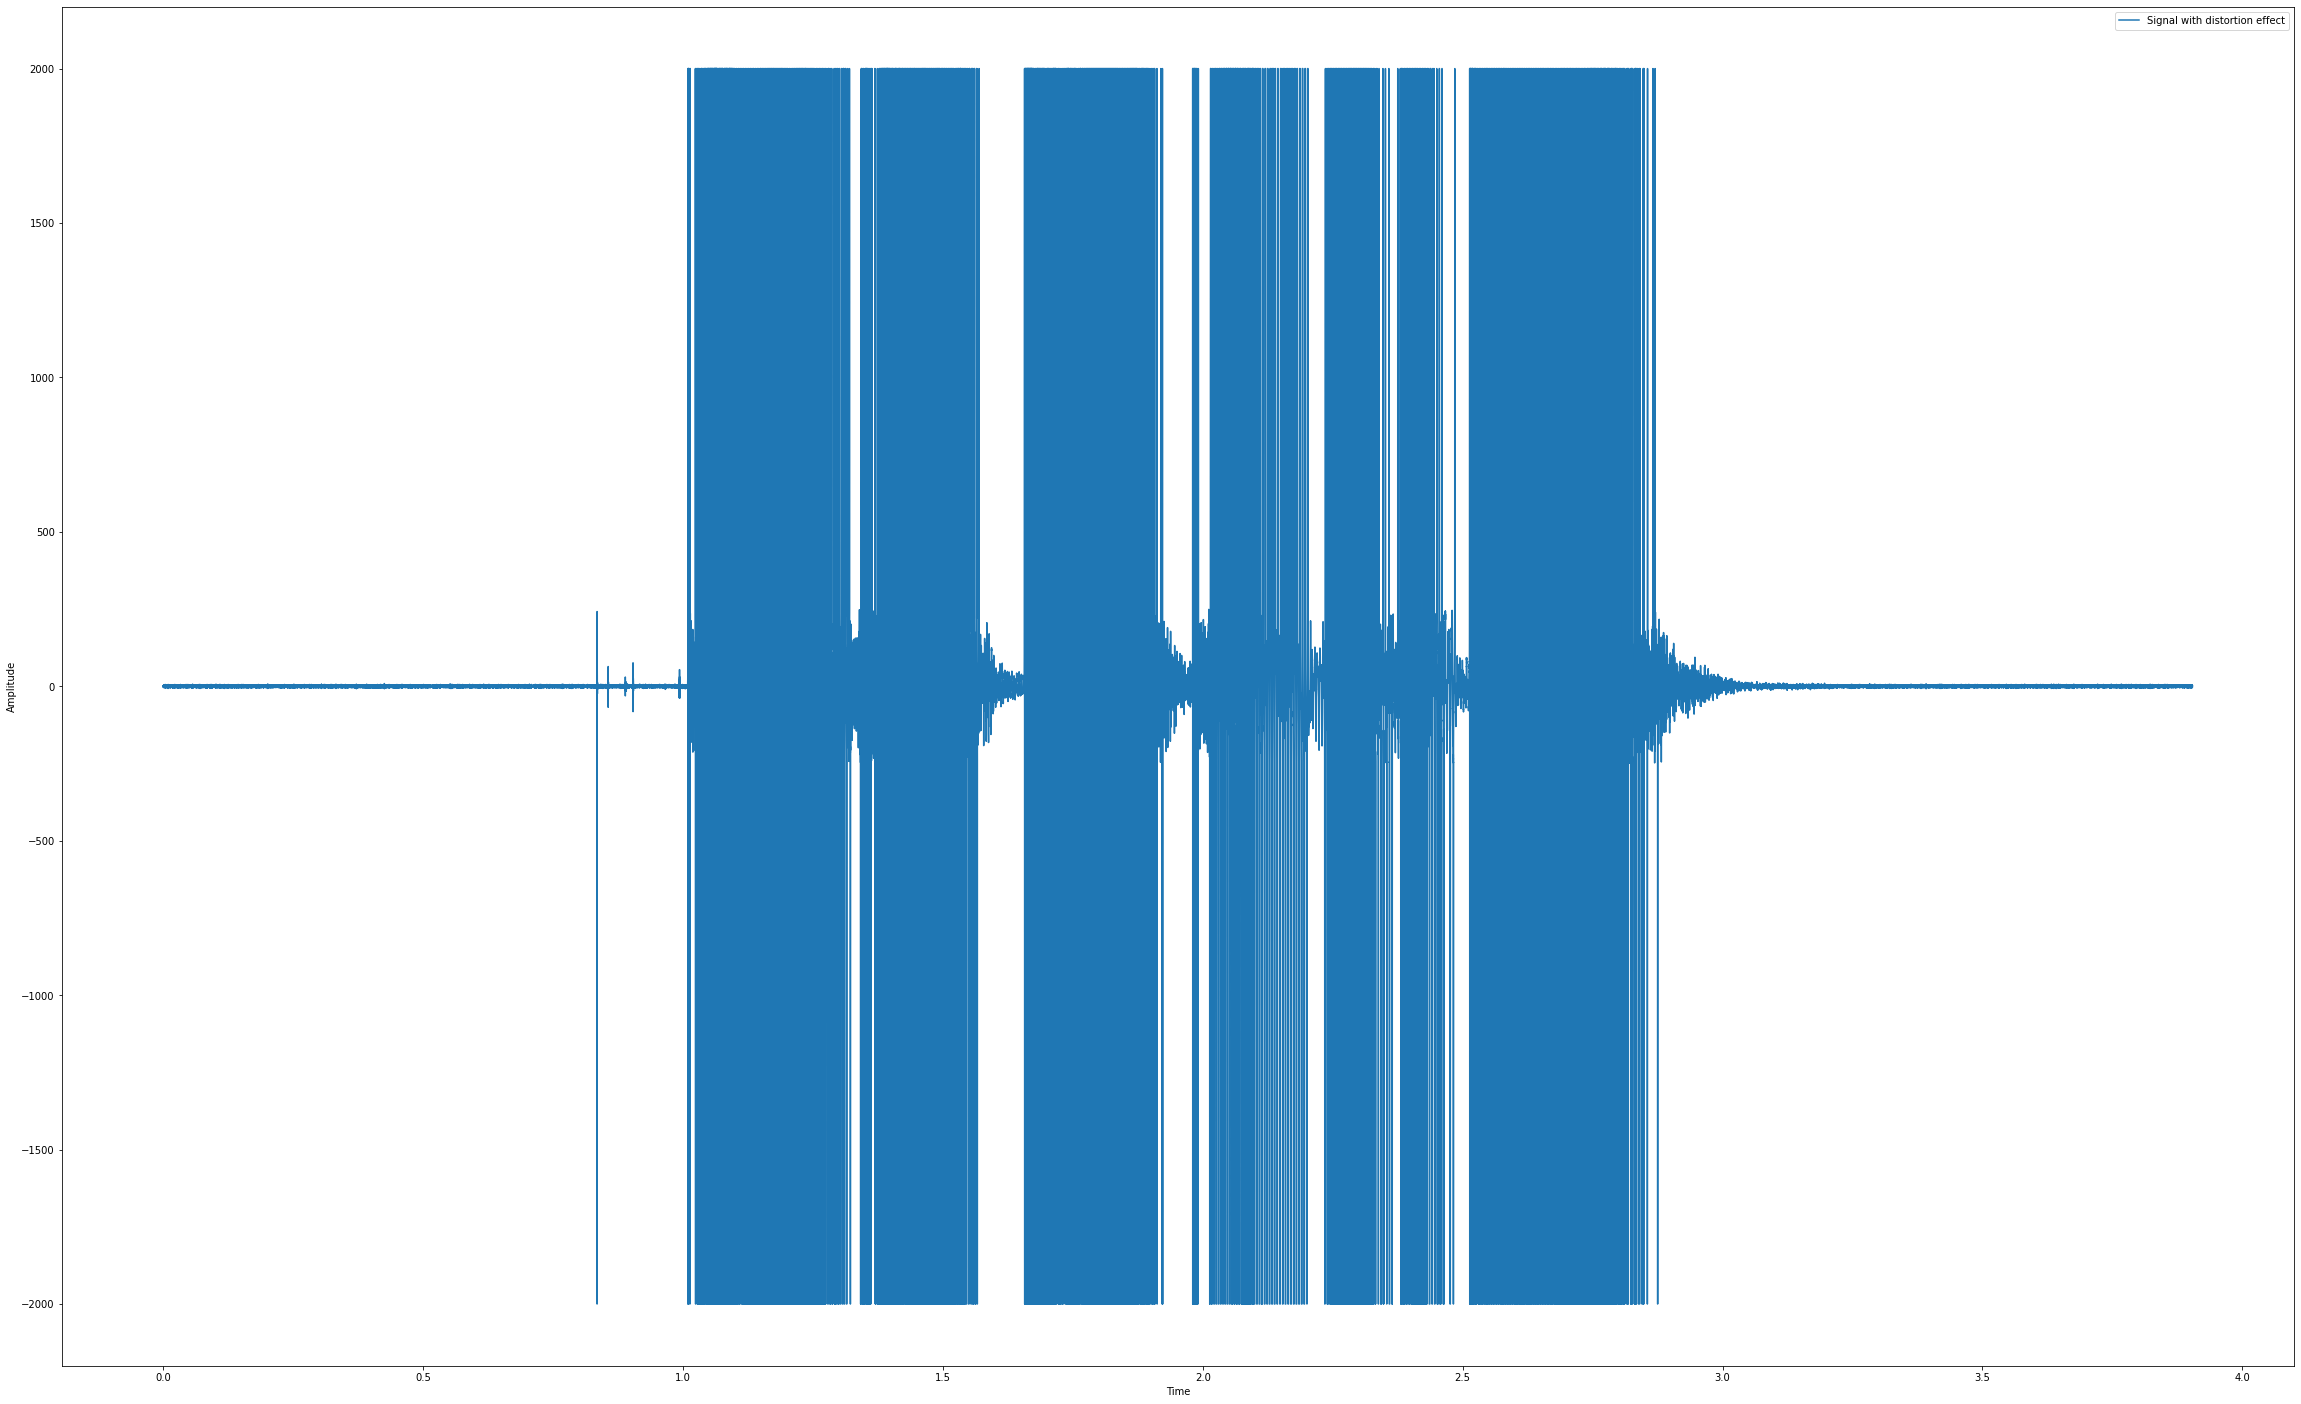

In [48]:
Th = 250
max = 2000
distortion = np.zeros(len(data))
for i in range(len(data)):
    if (abs(data[i]) < Th):
        distortion[i] = data[i]
    else:
        distortion[i] = max * np.sign(data[i])

wavfile.write('03-01-05-01-01-01-18_A18_distortion.wav',sampleRate, distortion.astype(np.int16))        
        
f = plt.figure()
f.set_figwidth(40)
f.set_figheight(25)
plt.plot(time, distortion, label="Signal with distortion effect")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

### Выводы по лабораторной работе
Были получены навыки работы с Jupyter Notebook, а также с библиотеками языка python - matplotlib, numpy, scipy, были получены навыки обработки и визуализации звуковых сигналов